In [1]:
#Import Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Import TensorFlow Dependencies - Functional API
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount ('/gdrive')

Mounted at /gdrive


## **TO BE CHANGED EVERYTIME**


In [4]:
# Setup Paths
POS_PATH = os.path.join("/gdrive/My Drive/King_Saud/Train/slug/", 'positive')
NEG_PATH = os.path.join("/gdrive/My Drive/King_Saud/Train/slug/", 'negative')
ANC_PATH = os.path.join("/gdrive/My Drive/King_Saud/Train/slug/", 'anchor')

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg')

In [6]:
def preprocess(file_path):
    # read in img from file path
    byte_img = tf.io.read_file(file_path)
    # load in the img
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the img to 100x100
    img = tf.image.resize(img, (100,100))
    # scale image between 1 & 0
    img = img/255.0
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [10]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [11]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
# Training Partition
train_data = data.take(round(len(data)*.9))
train_data = train_data.batch(4) # 4, 8, 16, 16
train_data = train_data.prefetch(4) # 4, 8, 8, 16

In [13]:
# testing Partition
test_data = data.skip(round(len(data)*.9))
test_data = test_data.take(round(len(data)*.1))
test_data = test_data.batch(4)
test_data = test_data.prefetch(4)

In [14]:
round(len(data)*.7)

440

In [15]:
round(len(data)*.3)

188

In [16]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embbedding):
        return tf.math.abs(input_embedding - validation_embbedding)

In [17]:
l1 = L1Dist()

In [18]:
from keras.applications import MobileNetV2
from keras.layers import Input, Flatten, Dense
from keras.models import Model

def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image input in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    base_model.trainable = False

    # Extract features from the two inputs
    input_features = base_model(input_image)
    validation_features = base_model(validation_image)

    # Combine Siamese distance components
    siamese_layer = L1Dist()  # Assuming you have L1Dist custom layer
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_features, validation_features)
    f1 = Flatten()(distances)

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(f1)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [19]:
siamese_model = make_siamese_model()

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)           2257984   ['input_img[0][0]',           
 tional)                                                             'validation_img[0][0]']      
                                                                                     

**5. Training**

5.1 Setup Loss and Optimizer

In [21]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [22]:
opt = tf.keras.optimizers.Adam(1e-4)

5.2 Establish Checkpoints

## **TO BE CHANGED EVERYTIME**

In [23]:
checkpoint_dir = './training_checkpoints_slug' #
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [24]:

@tf.function
def train_step(batch):

    # record all of our operations
    with tf.GradientTape() as tape:

        # Get anchor and =ve/-ve img
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y,yhat)

    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

5.4 Build Training Loop

In [25]:
from keras.metrics import Precision, Recall

In [30]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)

        # Calculate and print training accuracy and loss
        training_acc = (1 - loss) * 100
        print('Training accuracy: {:.2f}%'.format(training_acc))
        print('Training loss: {:.2f}'.format(loss))

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        '''desired_accuracy = 94

        if training_acc >= desired_accuracy:
            print('Desired accuracy ({:.2f}%) reached, stopping training'.format(desired_accuracy))
            break'''




5.5 Train the model

In [29]:
EPOCHS = 50

In [31]:
train(train_data, EPOCHS)

Streaming output truncated to the last 5000 lines.
Training accuracy: 99.99%
Training loss: 0.00

 Epoch 17/50
142/142 [==============================] - 18s 124ms/step
Training accuracy: 99.55%
Training loss: 0.00

 Epoch 18/50
142/142 [==============================] - 18s 125ms/step
Training accuracy: 99.96%
Training loss: 0.00

 Epoch 19/50
142/142 [==============================] - 18s 127ms/step
Training accuracy: 100.00%
Training loss: 0.00

 Epoch 20/50
142/142 [==============================] - 19s 133ms/step
Training accuracy: 99.65%
Training loss: 0.00

 Epoch 21/50
142/142 [==============================] - 18s 126ms/step
Training accuracy: 98.23%
Training loss: 0.02

 Epoch 22/50
142/142 [==============================] - 18s 127ms/step
Training accuracy: 99.64%
Training loss: 0.00

 Epoch 23/50
142/142 [==============================] - 19s 131ms/step
Training accuracy: 99.75%
Training loss: 0.00

 Epoch 24/50
142/142 [==============================] - 19s 133ms/step
Trai

**6. Evaluate the Model**

6.1 Import Metrics

In [32]:
# Import metric calculations
from tensorflow.keras.metrics import Precision,Recall

6.2 Make Predictions

1/1 [==============================] - 0s 30ms/step


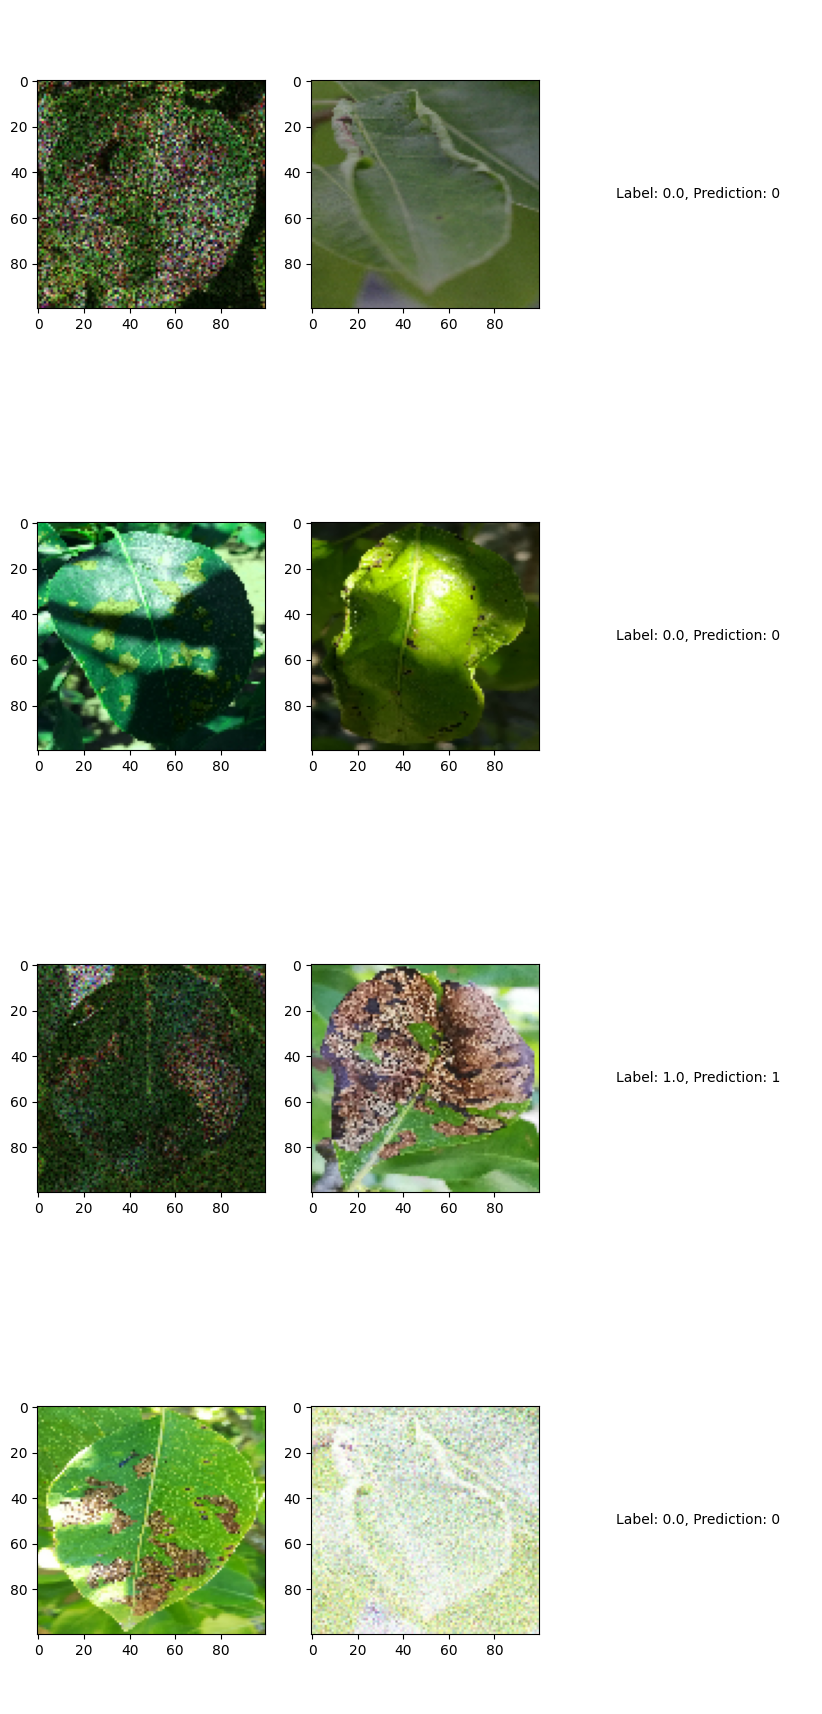

In [33]:
# Get the next batch of data from the test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Make predictions for the batch
y_hat = siamese_model.predict([test_input, test_val])
# Convert predictions to binary labels
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

# Create a figure with the number of rows equal to the batch size
fig, axes = plt.subplots(len(test_input), 3, figsize=(10, 22))

# Iterate over the images in the batch
for i in range(len(test_input)):
  # Display the images in the first column of the figure
  axes[i, 0].imshow(test_input[i])
  axes[i, 1].imshow(test_val[i])
  #axes[i, 0].imshow(test_input[i][:, :, 0],cmap='gray')
  #axes[i, 1].imshow(test_val[i][:, :, 0], cmap='gray')

  # Display the labels and predictions in the third column of the figure
  #axes[i, 2].set_title("Label: {}, Prediction: {}".format(y_true[i], y_hat[i]))
  text = "Label: {}, Prediction: {}".format(y_true[i], y_hat[i])
  axes[i, 2].text(0.5, 0.5, text, va='center', ha='center')
  axes[i, 2].set_xticks([])
  axes[i, 2].set_yticks([])
  for spine in axes[i, 2].spines.values():
      spine.set_visible(False)

# Show the figure
plt.show()


In [34]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [35]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 34ms/step


array([[2.5066524e-04],
       [9.9999464e-01],
       [9.9975389e-01],
       [9.9998248e-01]], dtype=float32)

In [36]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 1]

In [37]:
y_true

array([0., 1., 1., 1.], dtype=float32)

6.3 Calculating Metrics

In [38]:
# Initialize variables for storing results
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
num_batches = 0

# Iterate over the test data
for test_input, test_val, y_true in test_data.as_numpy_iterator():
  # Make predictions
  y_hat = siamese_model.predict([test_input, test_val])
  # Convert predictions to binary labels
  y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

  # Calculate accuracy
  accuracy = tf.keras.metrics.Accuracy()
  accuracy.update_state(y_true, y_hat)
  total_accuracy += accuracy.result().numpy()

  # Calculate precision
  precision = tf.keras.metrics.Precision()
  precision.update_state(y_true, y_hat)
  total_precision += precision.result().numpy()

  # Calculate recall
  recall = tf.keras.metrics.Recall()
  recall.update_state(y_true, y_hat)
  total_recall += recall.result().numpy()

  # Calculate F1 score
  f1 = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
  total_f1 += f1.numpy()

  num_batches += 1

# Calculate average test accuracy, precision, recall, and F1 score
avg_accuracy = total_accuracy / num_batches
avg_precision = total_precision / num_batches
avg_recall = total_recall / num_batches
avg_f1 = total_f1 / num_batches

# Print results
print("Test accuracy:", avg_accuracy)
print("Test precision:", avg_precision)
print("Test recall:", avg_recall)
print("Test F1 score:", avg_f1)


1/1 [==============================] - 1s 648ms/step
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test F1 score: 1.0


**7. Save Model**

## **TO BE CHANGED EVERYTIME**

In [39]:
# Save weights
siamese_model.save("MobileNetV2_Slug.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
